# Сборный проект 1 - Продажи компьютерных игр

## Введение

**Описание проекта**

Доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xboxили PlayStation). Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

**Описание данных**

1. `Name` — название игры
2. `Platform` — платформа
3. `Year_of_Release` — год выпуска
4. `Genre` — жанр игры
5. `NA_sales` — продажи в Северной Америке (миллионы проданных копий)
6. `EU_sales` — продажи в Европе (миллионы проданных копий)
7. `JP_sales` — продажи в Японии (миллионы проданных копий)
8. `Other_sales` — продажи в других странах (миллионы проданных копий)
9. `Critic_Score` — оценка критиков (максимум 100)
10. `User_Score` — оценка пользователей (максимум 10)
11. `Rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

## Предобработка данных

Для начала проверим какие данные нам достались. Нас интересуют:

1. Названия колонок и NaNs.
2. Артефакты в данных и строки-дубликаты.
3. Пропущенные значения.
4. Дополнительные параметры и типы данных.

Пойдем по порядку.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
from IPython.display import display
plt.style.use('default')

# Я привык сохранять исходный датасет, чтобы можно было проследить какие преобразования были совершены.
try:
    raw_games = pd.read_csv('games.csv')
except:
    raw_games = pd.read_csv('/datasets/games.csv')

# Проверим, что внутри датасета.
raw_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Надо переименновать заголовки и разобраться с типами данных в колонке `user_score`. Заметим, что есть много пропущенных значений в некоторых категориях - например, `critic_score`.

In [3]:
# Посмотрим на таблицу.
raw_games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Очень красивая таблица.

### Названия колонок и NaNs

Прежде, чем прыгнем в исследования, надо причесать этот датасет: сделать нормальные названия колонок, разобраться со старнными значениями в столбцах.

In [4]:
# Нормальный регистр для колонок.
df_games = raw_games
df_games.columns = df_games.columns.str.lower()

# Функция для определения колонок с null или non_numeric_values.
def fun_get_columns_with_non_numeric_values(df):
    """
    This function looks for non numeric values (e.g.: 'tbd') in columns which should have been numeric.
    It returns what are the non numeric values inside and a list of columns that have them.

    Args:
        df (DataFrame): A dataframe to check.
        
    Returns:
        columns_with_nan (list): List of columns with non numeric values.
    """
    columns_with_nan = []
    
    for column in df.columns:
        rows_with_null = df[column].isna()
        rows_with_nan = pd.to_numeric(df[column], errors='coerce').isna()
        
        if (rows_with_nan.sum() > 0) & (rows_with_nan.sum() != rows_with_null.sum()):
            columns_with_nan.append(column)
            print('-' * 50)
            print(df[column][rows_with_nan].value_counts())
            
    print('-' * 50)
    print('Columns with non numeric values:')
    print(columns_with_nan)
    print('-' * 50)
    return columns_with_nan

# Посмотрим, что получилось.
fun_get_columns_with_non_numeric_values(df_games[['na_sales',
                                                   'eu_sales',
                                                   'jp_sales',
                                                   'other_sales',
                                                   'critic_score',
                                                   'user_score',
                                                   'year_of_release']]);

--------------------------------------------------
tbd    2424
Name: user_score, dtype: int64
--------------------------------------------------
Columns with non numeric values:
['user_score']
--------------------------------------------------


`tbd` - это зашифрованное `to be determined`. Видимо, `user_score` для некоторых игр еще не был посчитан по каким-то причинам.Надо исправить, иначе не сможем задать правильный тип данных.

In [5]:
# Заменими tbd значения на np.nan - они будут исправлены дальше.
df_games.user_score.replace('tbd', np.nan, inplace=True)
df_games = df_games.astype({'user_score': 'float64'})

# Посмотрим, что получилось
fun_get_columns_with_non_numeric_values(df_games[['na_sales',
                                                   'eu_sales',
                                                   'jp_sales',
                                                   'other_sales',
                                                   'critic_score',
                                                   'user_score',
                                                   'year_of_release']]);

--------------------------------------------------
Columns with non numeric values:
[]
--------------------------------------------------


### Артефакты в данных и строки-дубликаты



Следующим шагом посмотрим на артефакты в данных и потенциальные строки-дубликаты.

In [6]:
# Посмотрим на распределения внутри количественных колонок.
display(round(df_games.describe(), 2))

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score
count,16446.00,16715.00,16715.00,16715.00,16715.00,8137.00,7590.00
mean,2006.48,0.26,0.15,0.08,0.05,68.97,7.13
std,5.88,0.81,0.50,0.31,0.19,13.94,1.50
min,1980.00,0.00,0.00,0.00,0.00,13.00,0.00
25%,2003.00,0.00,0.00,0.00,0.00,60.00,6.40
50%,2007.00,0.08,0.02,0.00,0.01,71.00,7.50
75%,2010.00,0.24,0.11,0.04,0.03,79.00,8.20
max,2016.00,41.36,28.96,10.22,10.57,98.00,9.70


Что видно из статистики.

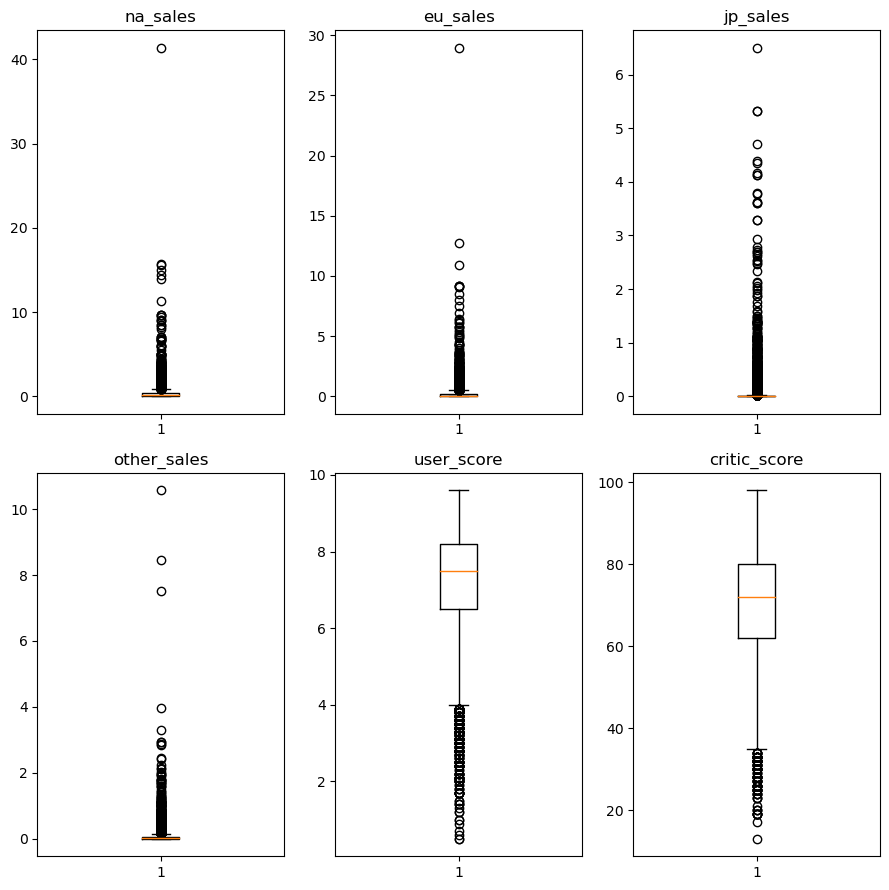

In [7]:
def fun_get_boxplots_for_columns(df, columns, num_rows, num_columns):
    """
    This function creates a num_rows x num_columns box subplots for a list of columns out of the dataset.

    Args:
        df (DataFrame): dataframe with data to show.
        columns (List): list of columns to plot.
        num_rows (int): number of rows in subplots.
        num_columns (int): number of columns in subplots.
    """
    # Для начала коробки с усами.
    fig, axs = plt.subplots(num_rows, num_columns, figsize=(9, 9))

    # Добавим каждый бокс-с-усами к фигуре.
    for i, ax in enumerate(axs.flat):
        ax.boxplot(df[columns].dropna().iloc[:, i])
        ax.set_title(df[columns].columns[i])

    # Сделаем нормальный формат графиков и удалим ненужные переменные.
    plt.tight_layout()

fun_get_boxplots_for_columns(df_games, ['na_sales', 'eu_sales', 'jp_sales', 'other_sales',
                                        'user_score', 'critic_score', 'year_of_release'], 2, 3)

Бросаются в глаза длинные хвосты продаж в разных регионах. Надо будет их обрезать.

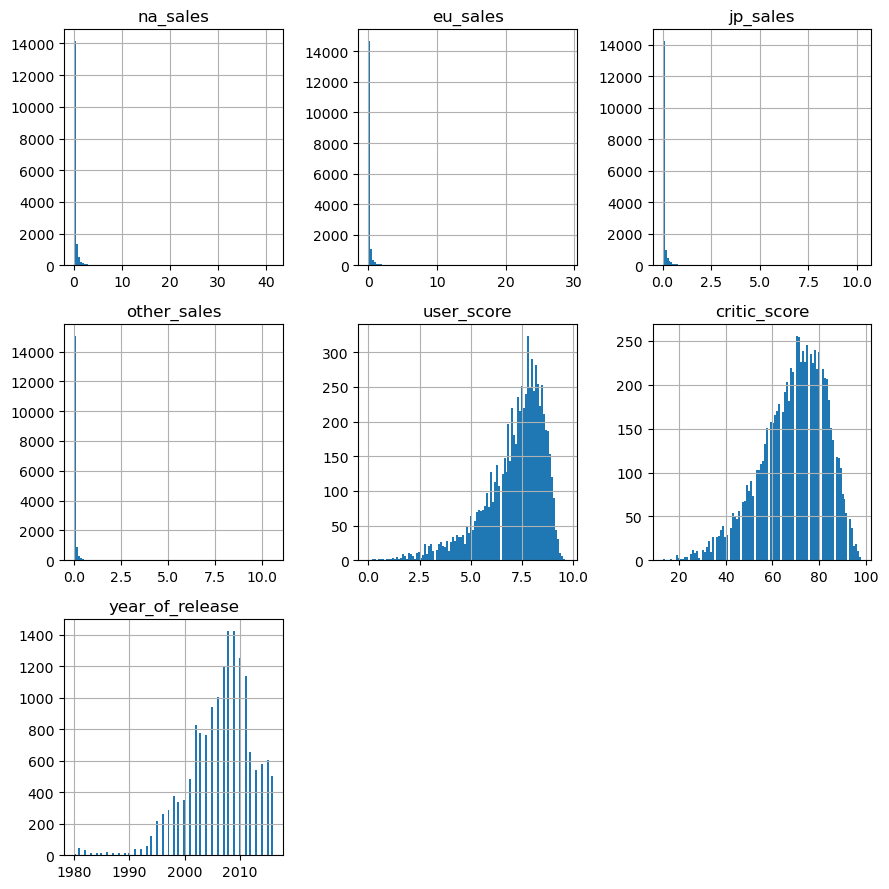

In [8]:
df_games[['na_sales', 'eu_sales', 'jp_sales', 'other_sales',
          'user_score', 'critic_score', 'year_of_release']].hist(bins=100,
                                                                 figsize=(9, 9));
plt.tight_layout();

`user_score`, `critic_score` и `year_of_release` выглядят крайне правдоподобно: немного скошенные нормальные распределения. А вот продажи по регионам (как мы увидели на прошлом графике) имеют длинные хвосты.

Обрежем наш датасет по году выпуска (не интересны нам игры выпущенные до моего рождения) и по продажам в регионах. В колонке год выпуска надо оставить `null`'s: их не восстановить статистическими методами, но и выбрасывать пока не стоит. Разберемся с ними по ходу дела.

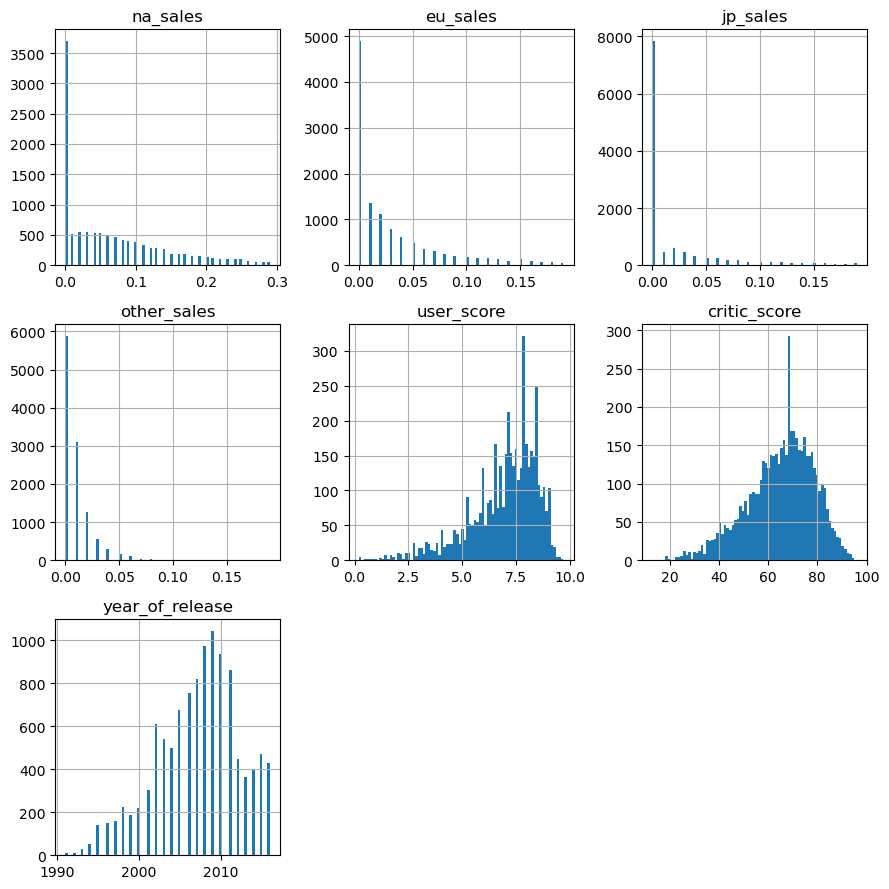

In [9]:
# Обрежем по продажам и по году выпуска.
df_games = df_games[ df_games.na_sales < .3 ]
df_games = df_games[ df_games.eu_sales < .2 ]
df_games = df_games[ df_games.jp_sales < .2 ]
df_games = df_games[ df_games.other_sales < .2 ]
df_games = df_games[ (df_games.year_of_release > 1990) | (df_games.year_of_release.isna()) ]

# Посмотрим, что получилось.
df_games[['na_sales', 'eu_sales', 'jp_sales', 'other_sales',
          'user_score', 'critic_score', 'year_of_release']].hist(bins=80,
                                                                 figsize=(9, 9));
plt.tight_layout();

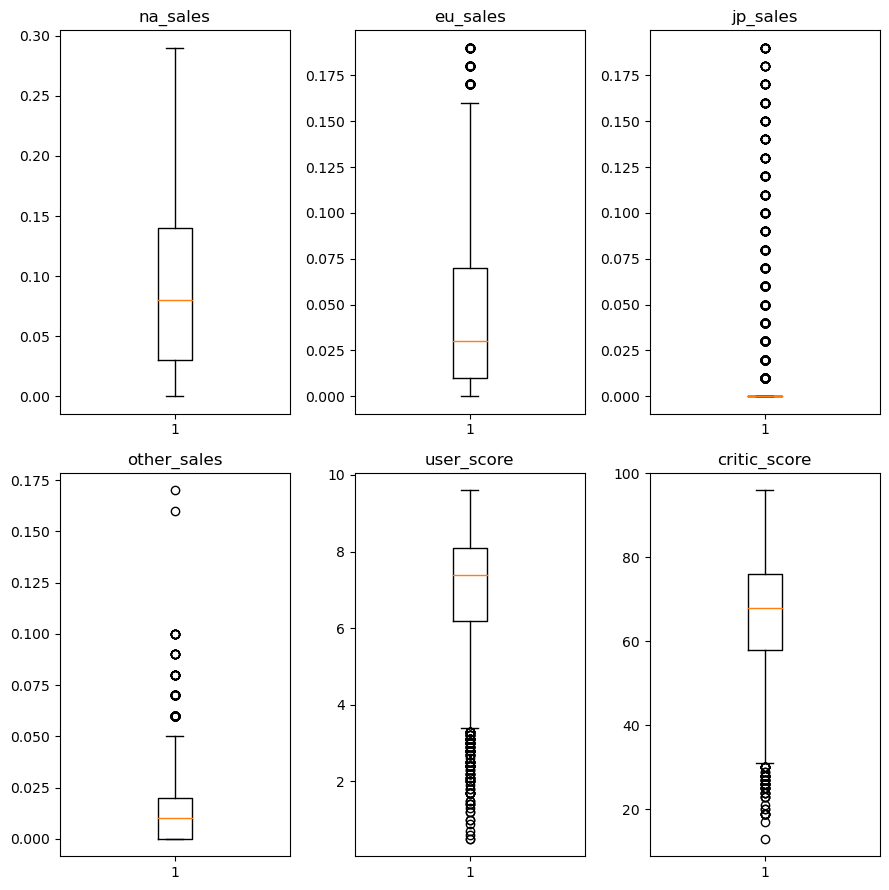

In [10]:
fun_get_boxplots_for_columns(df_games, ['na_sales', 'eu_sales', 'jp_sales', 'other_sales',
                                        'user_score', 'critic_score', 'year_of_release'], 2, 3)

Так намного лушче. Посмотрим на дубликаты.

In [11]:
# Полные дубликаты.
print( 'Количество строк-дубликатов:', df_games.duplicated().sum() )

Количество строк-дубликатов: 0


Похоже, полных дубликатов нет! Ну и хорошо.

### Пропущенные значения

Найдем и, если можно, восстановим.

In [12]:
# Найдем колонки с пропущенными значениями через функцию - нам надо будет сделать это пару раз.
def fun_get_columns_with_nan(df):
    """
    This function returns a list of column names, which have null or NaN values.

    Args:
        df (DataFrame): A dataframe to check.

    Returns:
        columns_with_nan (list): A list of column names which have nulls or NaNs inside.
    """
    columns_with_null = []

    for column in df.columns:
        if df[column].isna().sum() > 0:
            columns_with_null.append(column)
    return columns_with_null

# Посмотрим на них.
fun_get_columns_with_nan(df_games)

['name', 'year_of_release', 'genre', 'critic_score', 'user_score', 'rating']

Из всех колонок мы можем восстановить только `critic_score` и `user_score`. Остальные придется оставить как неизвестные, потому что не можем ничего про них сказать.

В колонке год выпуска занчения заполним нулями. Так будет понятно, что это замещение пустых значений, но также даст нам задать тип данных `int`.

In [13]:
# Fill in NaNs in category columns with unknowns. For `year_or_release` we will just set zeros.
df_games[['name', 'genre', 'rating']] = df_games[['name', 'genre', 'rating']].fillna('unknown')
df_games.year_of_release.fillna(0, inplace=True)

# Восстановим по медианным значениям.
# Лучше бы восстановить по производителям, но такой информации нет.
df_games.critic_score.fillna(df_games.critic_score.median(), inplace=True)
df_games.user_score.fillna(df_games.user_score.median(), inplace=True)

# Посмотрим что получилось.
fun_get_columns_with_nan(df_games)

[]

### Дополнительные значения и типы данных

Добавим суммарные продажи по всем регионам. После этого, можем задать типы данных в каждых колонках.

In [14]:
# Добавим суммарные продажи.
df_games['total_sales'] = raw_games.na_sales + raw_games.eu_sales + raw_games.jp_sales + raw_games.other_sales

# Зададим типы данных.
df_games = df_games.astype({'name': 'object',
                            'platform': 'object',
                            'year_of_release': 'int64',
                            'genre': 'object',
                            'na_sales': 'float64',
                            'eu_sales': 'float64',
                            'jp_sales': 'float64',
                            'other_sales': 'float64',
                            'critic_score': 'int64',
                            'user_score': 'float64',
                            'rating': 'object',
                            'total_sales': 'float64'})

# Посмотрим, что получилось.
display(df_games.head())

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
2973,Minecraft,WiiU,2016,Misc,0.28,0.17,0.18,0.04,67,7.3,unknown,0.67
3151,New Play Control! Pikmin,Wii,2008,Strategy,0.28,0.12,0.19,0.04,67,7.3,unknown,0.63
3307,Dragon Ball Z: Ultimate Tenkaichi,PS3,2011,Fighting,0.27,0.18,0.09,0.07,58,5.4,T,0.61
3333,Dead Island: Riptide,PS3,2013,Action,0.26,0.19,0.07,0.09,62,5.9,M,0.61
3367,New Play Control! Donkey Kong Jungle Beat,Wii,2008,Platform,0.23,0.17,0.14,0.05,67,7.3,unknown,0.59


## Исследовательский анализ данных

Посмотрим, какие глобальные закономерности мы можем найти в данных. Поисследуем как продажи игр распределны по годам и по платформам.

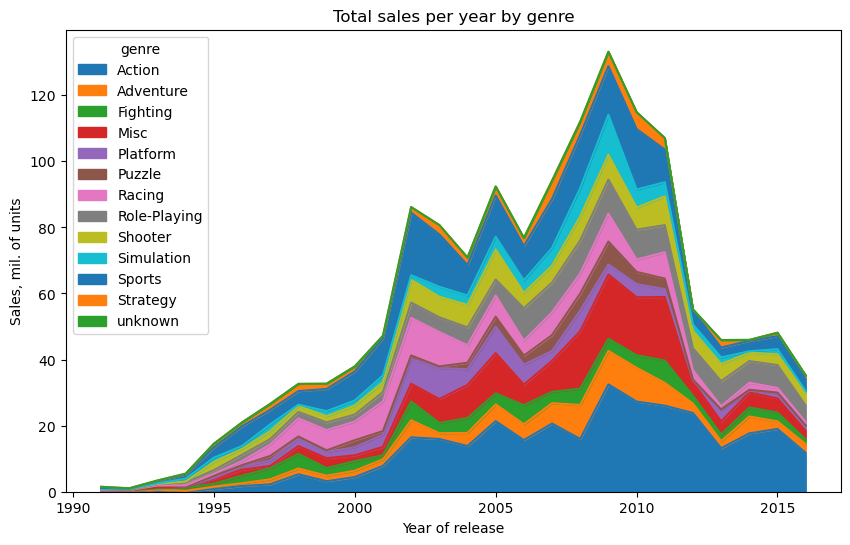

In [15]:
# Total sales per year.
pd.pivot_table(df_games[df_games.year_of_release != 0],
               values='total_sales',
               index='year_of_release',
               columns='genre',
               aggfunc='sum')\
  .plot(kind='area',
        title='Total sales per year by genre',
        xlabel='Year of release',
        ylabel='Sales, mil. of units',
        figsize=(10, 6));

Очень красивый график. Сразу видно, что есть некоторые жанры, которые пользуются большей популярностью, чем другие - `action`, `misc`, `sports`. Жанр `strategy` оказался одним из самых маленьких. Где-то грустит Керриган.

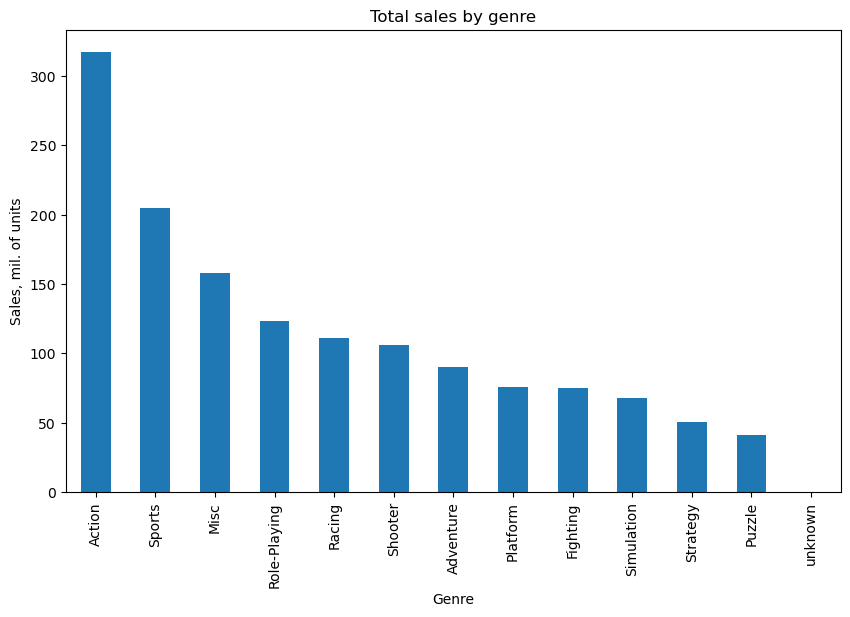

In [16]:
# Total sales per year.
pd.pivot_table(df_games[df_games.year_of_release != 0],
               values='total_sales',
               index='genre',
               aggfunc='sum')\
  .sort_values(by='total_sales',
               ascending=False)\
  .plot(kind='bar',
        y='total_sales',
        title='Total sales by genre',
        xlabel='Genre',
        ylabel='Sales, mil. of units',
        legend=False,
        figsize=(10, 6));

Как и ожидалось, продажи не распределены равномерно по жанрам. Более "попсовые" жанры имеют высокие продажи (`Call of Duty` самая продаваемся игра всех времен и народов после `Mario`?).

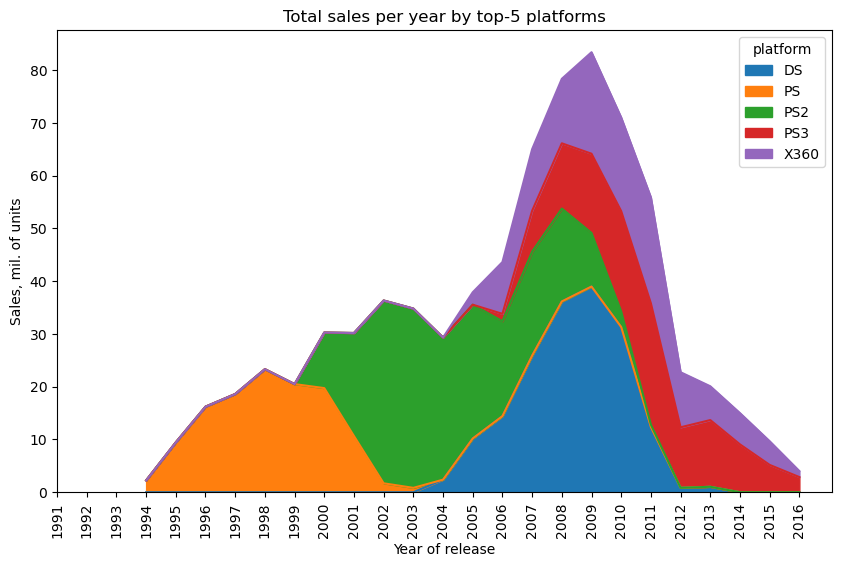

In [17]:
# Top-5 platforms by total sales.
lut_top5_platforms = pd.pivot_table(df_games[df_games.year_of_release != 0],
                                    values='total_sales',
                                    index='platform',
                                    aggfunc='sum')\
                       .sort_values(by='total_sales',
                                    ascending=False)\
                       .head(5)\
                       .index\
                       .values
                       
# Total sales per year for top-5 platforms.
pd.pivot_table(df_games[(df_games.year_of_release != 0) &
                        (df_games.platform.isin(lut_top5_platforms))],
               values='total_sales',
               index='year_of_release',
               columns='platform',
               aggfunc='sum')\
   .plot(kind='area',
         xticks=df_games[df_games.year_of_release != 0].year_of_release.unique(),
         rot=90,
         title='Total sales per year by top-5 platforms',
         xlabel='Year of release',
         ylabel='Sales, mil. of units',
         figsize=(10, 6));

Похоже, что-то произошло в 2011-2013 годах: количество проданных копий снизилось в несколько почти по всем категориям! Для дальнейших приключений возмем данные начиная с 2013 года, думаю, они будут наиболее реперезентативными.

Из этого графика также можно прикинуть средний срок жизни платформы - он составляет около 10 лет: PS с 1994 по 2003, DS с 2003 по 2012 и PS2 с 1999 по 2011.

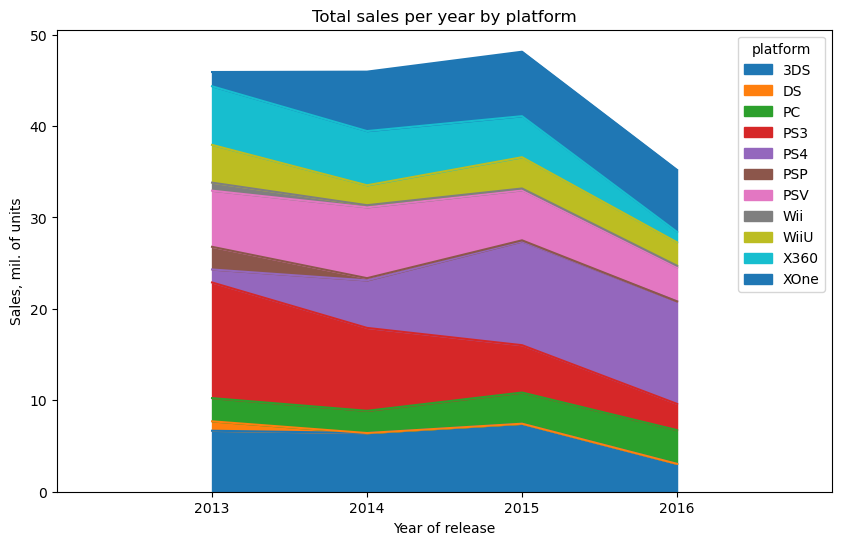

In [18]:
# Cut data we don't need anymore.
df_games = df_games[ df_games.year_of_release >= 2013 ]

# Let's check how sales are distributed per platform.
pd.pivot_table(df_games,
               values='total_sales',
               index='year_of_release',
               columns='platform',
               aggfunc='sum')\
   .plot(kind='area',
         xticks=df_games.year_of_release.unique(),
         legend=True,
         title='Total sales per year by platform',
         xlabel='Year of release',
         xlim=(2012, 2017),
         ylabel='Sales, mil. of units',
         figsize=(10, 6));

Продажи по платформам также неравномерные. Удивительно, что продажи для ПК не в первой тройке. Продажи по различным моделями PlayStation разняться, но это ожидаемо: люди переходят со старой версии железа на новую. Оцифруем, как эти платформы выросли или упали за выбранный период.

In [19]:
# Check which platforms were growing.
pd.pivot_table(df_games[(df_games.year_of_release == 2013) |
                        (df_games.year_of_release == 2016)],
               values='total_sales',
               index='platform',
               columns='year_of_release',
               aggfunc='sum')\
  .sort_values(by=2016,
               ascending=False)

year_of_release,2013,2016
platform,,
PS4,1.42,11.21
XOne,1.56,6.78
PSV,6.14,3.72
PC,2.54,3.69
3DS,6.67,3.05
PS3,12.65,2.87
WiiU,4.13,2.56
X360,6.41,1.14
Wii,0.88,0.18


`PS4`, `XOne`, `PSV`, и `PC` являются одними из самых популярных платформ, с точки зрения продаж. Надо помнить, что платформы имеют некоторые период полураспада, поэтому высокие продажи сейчас не гарантируют высокие продажи потом.

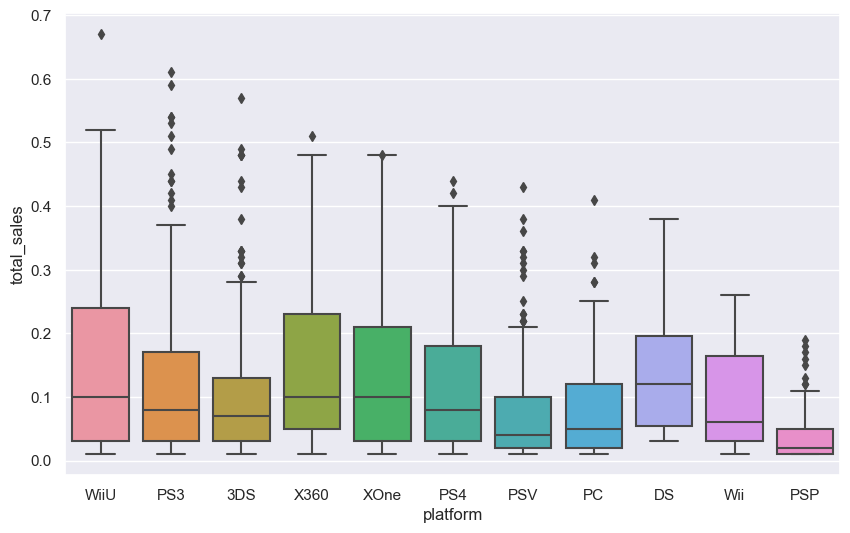

In [20]:
# Total sales per platform
sns.set(rc = {'figure.figsize': (10, 6)})
sns.boxplot(data=df_games,
            x='platform',
            y='total_sales');

Похоже, продажи по платформам имеют сильо разные рспределения. Интересно, что на `PS3` у нас может быть много выбросов в сравнении с `Wii`, например. Сложно сказать, что является причиной такой картинки.

Посмотрим, как влияют отзывы покупателей и критиков на продажи для одной из платформ. Возьмем `PS4` из предыдущего упражнения, потому что эта платформа самая большая в 2016 году.

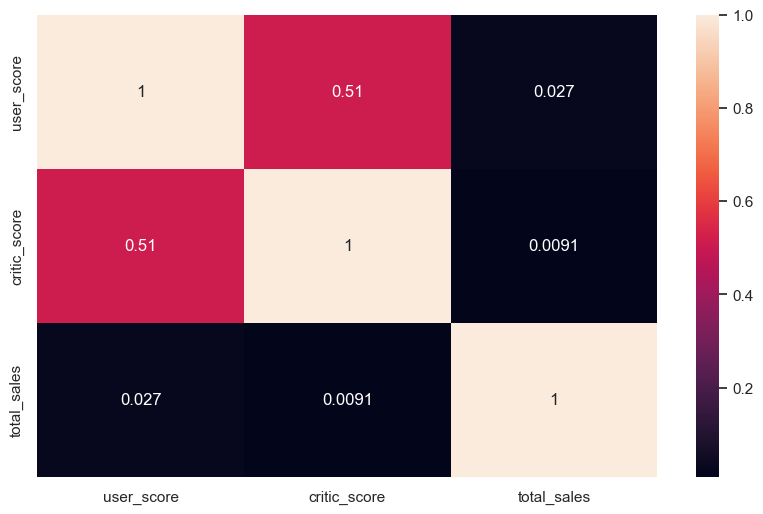

In [21]:
# Show me linear correlations.
sns.heatmap(pd.pivot_table(df_games,
                values='total_sales',
                index=['user_score', 'critic_score'],
                aggfunc='sum')\
              .reset_index()\
              .corr(),
            annot=True);

Похоже, зависимости нет? Это неожиданно, но возможно. Может, люди смотрят YouTube описания игр, вместо каких-то официальных рейтингов.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


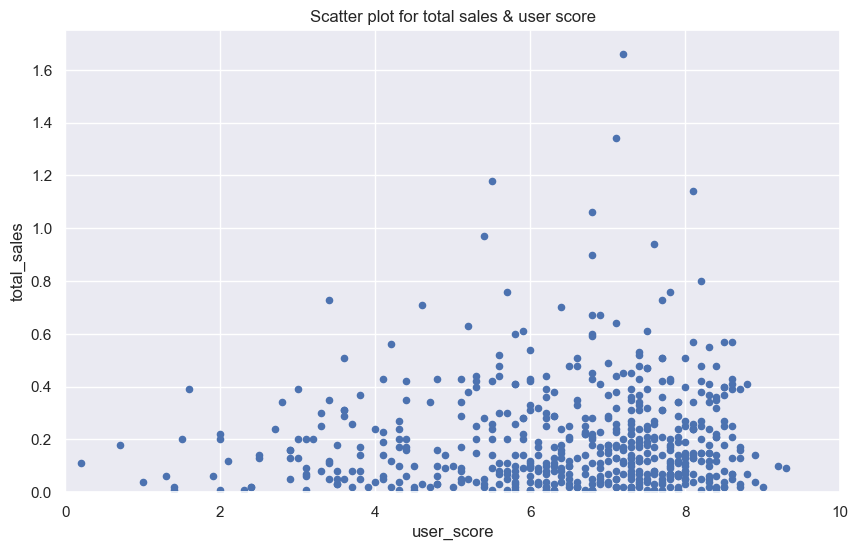

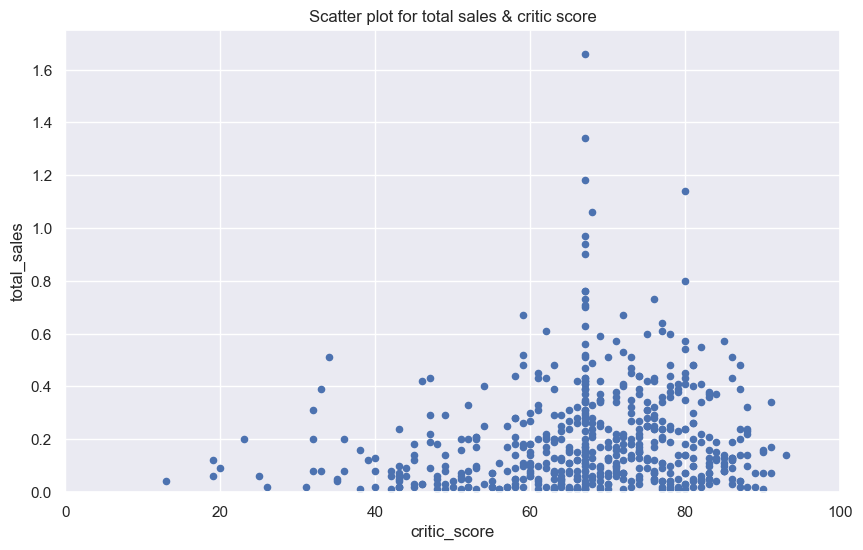

In [22]:
# Show me scatter plot for user_score.
pd.pivot_table(df_games,
               values='total_sales',
               index=['user_score', 'critic_score'],
               aggfunc='sum')\
  .reset_index()\
  .plot(kind='scatter',
        x='user_score',
        y='total_sales',
        xlim=(0, 10),
        ylim=(0, 1.75),
        title='Scatter plot for total sales & user score');
  
# Show me scatter plot for user_score.
pd.pivot_table(df_games,
               values='total_sales',
               index=['user_score', 'critic_score'],
               aggfunc='sum')\
  .reset_index()\
  .plot(kind='scatter',
        x='critic_score',
        y='total_sales',
        xlim=(0, 100),
        ylim=(0, 1.75),
        title='Scatter plot for total sales & critic score');

Выводы: похоже, что действительно нет выраженной зависимости: точки размазаны по всей картинке.

Посмотрим теперь что происходит с жанрами.

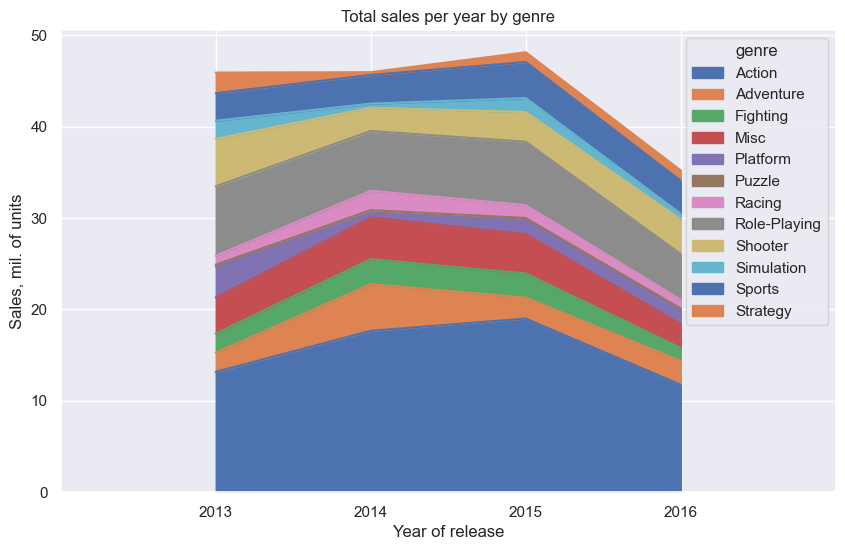

In [23]:
# Let's check how sales are distributed per platform.
pd.pivot_table(df_games,
               values='total_sales',
               index='year_of_release',
               columns='genre',
               aggfunc='sum')\
   .plot(kind='area',
         xticks=df_games.year_of_release.unique(),
         legend=True,
         title='Total sales per year by genre',
         xlabel='Year of release',
         xlim=(2012, 2017),
         ylabel='Sales, mil. of units',
         figsize=(10, 6));

Как мы увидели на прошлом графике, продажи по жанрам распределены неравномерно. Самые популярные жанры: `Action`, `RPG` и `Shooter`.  

## Портрет пользователя в различных регионах

Посмотрим, какие популярные платформы и жанры есть в разных регионах. А также как рейтинг ESRB влияет на продажи.

<Figure size 1000x600 with 0 Axes>

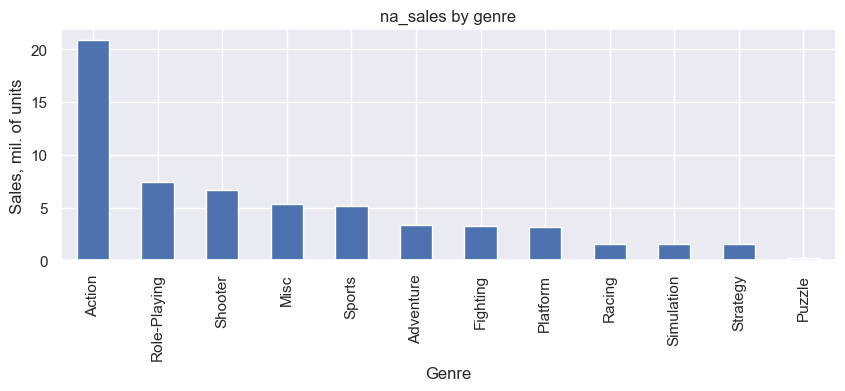

<Figure size 1000x600 with 0 Axes>

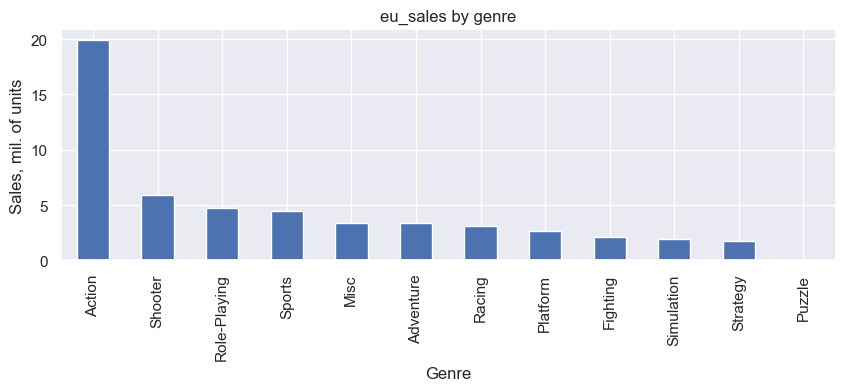

<Figure size 1000x600 with 0 Axes>

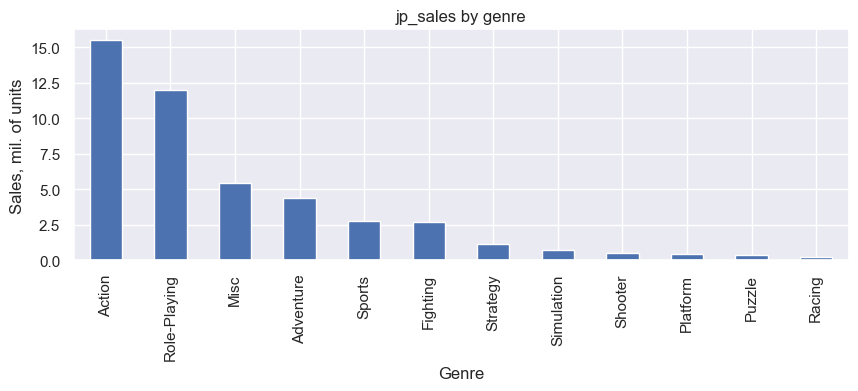

In [24]:
# Top-5 genres per region.
for region_sales in ['na_sales', 'eu_sales', 'jp_sales']:
    plt.figure();
    pd.pivot_table(df_games,
                values=region_sales,
                index='genre',
                aggfunc='sum')\
    .sort_values(by=region_sales,
                ascending=False)\
    .plot(kind='bar',
          y=region_sales,
          title=region_sales + ' by genre',
          xlabel='Genre',
          ylabel='Sales, mil. of units',
          legend=False,
          figsize=(10, 3));

Из графиков видно, что пользователи разных регионов предпочитают разные жанры (хотя жанр `Action` остается на первом в каждой выборке). Суммарные продажи также разнятся: я думаю, будет справедливо сказать, что Северная Америка толкает рынок видеоигр в целом.

Интересно, если проигнорировать жанр `Action`, то продажи в Европе и Северной Америке достаточно равномерно распределны по остальным жанрам. А вот в Японии не так: здесь есть еще один явный лидер `RPG`, который близко стоит рядом с `Action`. 

<Figure size 1000x600 with 0 Axes>

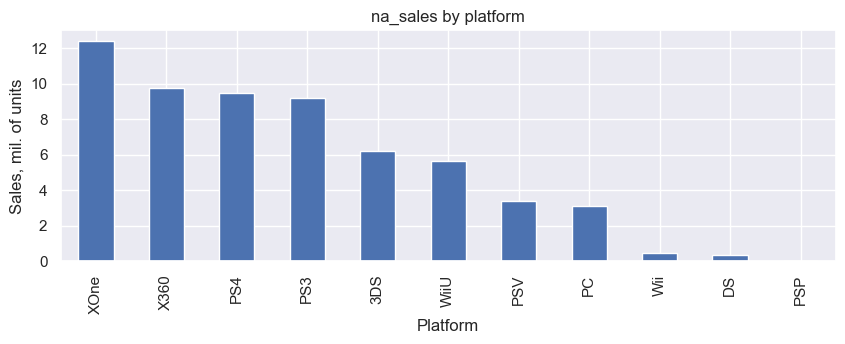

<Figure size 1000x600 with 0 Axes>

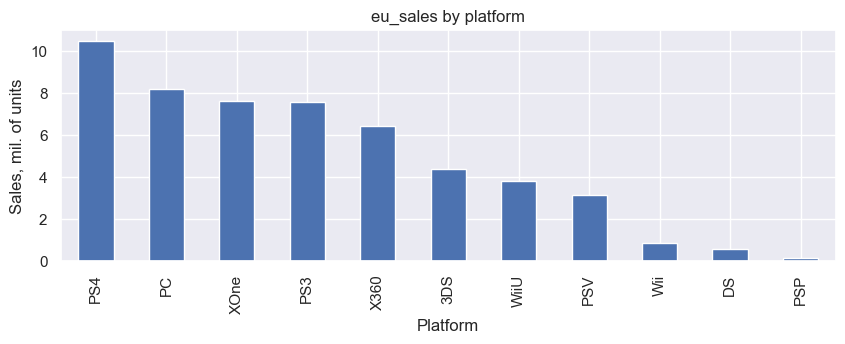

<Figure size 1000x600 with 0 Axes>

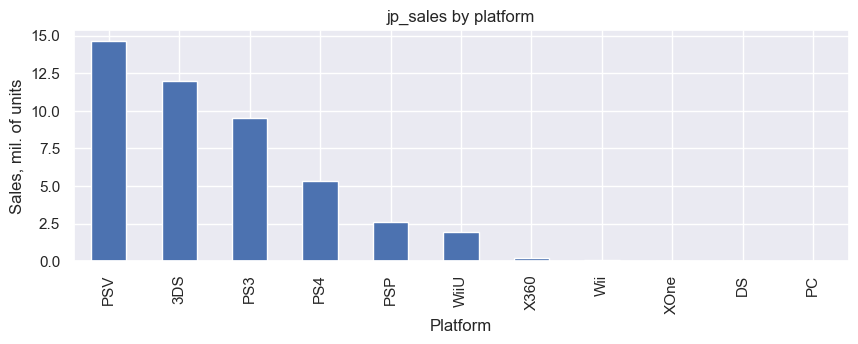

In [25]:
# Top-5 platforms per region.
for region_sales in ['na_sales', 'eu_sales', 'jp_sales']:
    plt.figure();
    pd.pivot_table(df_games,
                values=region_sales,
                index='platform',
                aggfunc='sum')\
    .sort_values(by=region_sales,
                ascending=False)\
    .plot(kind='bar',
          y=region_sales,
          title=region_sales + ' by platform',
          xlabel='Platform',
          ylabel='Sales, mil. of units',
          legend=False,
          figsize=(10, 3));

Очень похожую картинку мы видим в продажах по платформам, но в этом случае лидеры продаж разные. В Северной Америке лидируют консоли Микрософт и Сони. В Еропе Сони также популярна, но ПК игры занимают второе место. А вот в Японии все совсем по-другому: продажи на X-Box и ПК почти не существуют! Зато большой популярностью пользуются мобильные устройства.

<Figure size 1000x600 with 0 Axes>

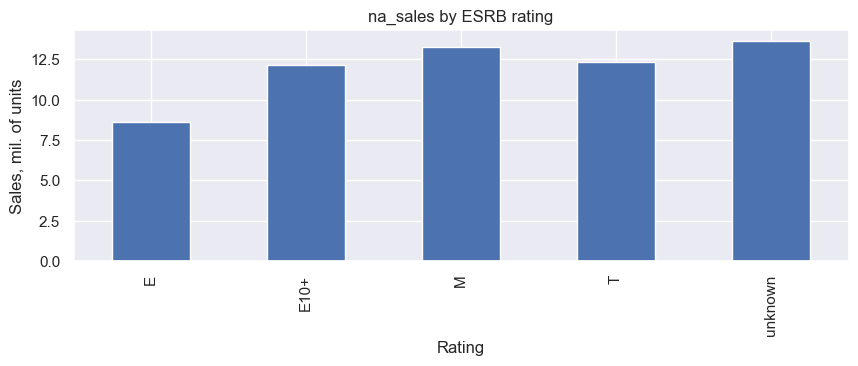

<Figure size 1000x600 with 0 Axes>

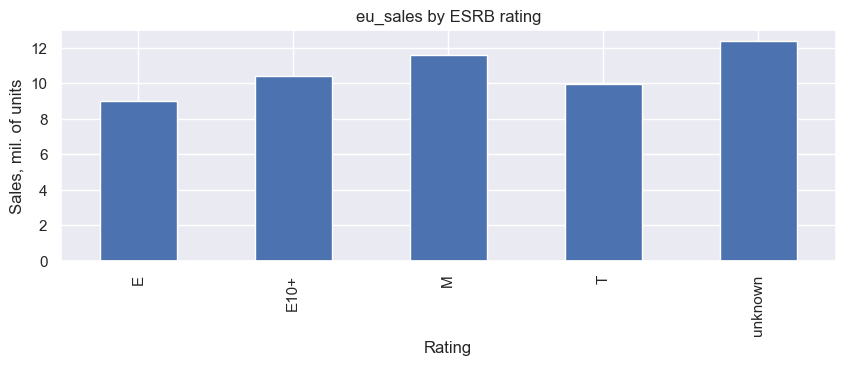

<Figure size 1000x600 with 0 Axes>

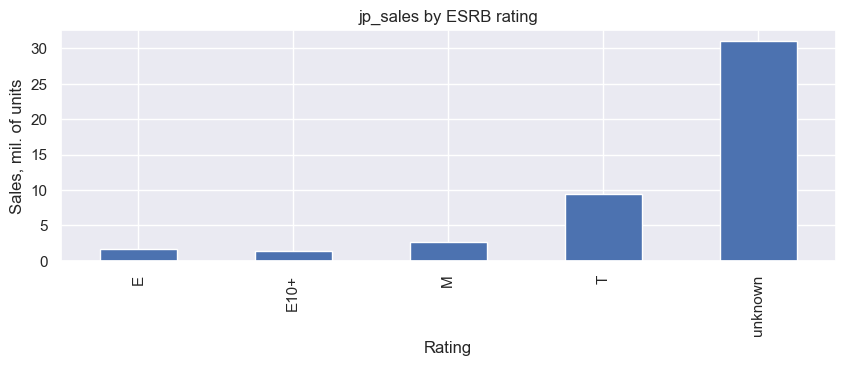

In [26]:
# ESRB rating influence on sales.
for region_sales in ['na_sales', 'eu_sales', 'jp_sales']:
    plt.figure();
    pd.pivot_table(df_games,
                values=region_sales,
                index='rating',
                aggfunc='sum')\
    .plot(kind='bar',
          y=region_sales,
          title=region_sales + ' by ESRB rating',
          xlabel='Rating',
          ylabel='Sales, mil. of units',
          legend=False,
          figsize=(10, 3));

Снова Япония сильно отличается от остального мира. Здесь много игр не имеют ESRB рейтинга совсем (вероятно, потому что большая часть продаж приходится на мобильные утройства). Также в Японии видно, что рейтинг `T` значительно более популярен, чем остальные рейтинги. Вероятно, потому что это игры для детей от 13 лет.

Рейтинг ESRB в Европе и Северной Америке, похоже, не сильно влияет на продажи: они распределены достаточно равномерно.

## Проверка гипотез

Перейдем к проверке гипотез. С точки зрения статистики, первая гипотеза может может быть записано как:

> Нулевая гипотеза: средние пользовательские рейтинги платформ `Xbox One` и `PC` одинаковые.

> Альтернативная гипотеза: средние пользовательские рейтинги платформ `Xbox One` и `PC` разные.

Это проверть просто, т.к. среднее можно посчитать напрямую. Но в качестве упражнения, интересно, что покажут статистические методы.

In [27]:
# Вычислим среднее по каждой выборке и выведем на экран
print('Средний пользовательский рейтинг на платформе XOne:', 
      round(df_games[df_games.platform == 'XOne'].user_score.mean(), 2))
print('Средний пользовательский рейтинг на платформе PC:', 
      round(df_games[df_games.platform == 'PC'].user_score.mean(), 2))

Средний пользовательский рейтинг на платформе XOne: 6.83
Средний пользовательский рейтинг на платформе PC: 6.52


In [28]:
# То же самое но с помощью scipy.
# t-тест
results = st.ttest_ind(
    df_games[df_games.platform == 'XOne'].user_score, 
    df_games[df_games.platform == 'PC'].user_score)

print('p-значение:', round(results.pvalue, 3))

if results.pvalue < .05:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.057
Не получилось отвергнуть нулевую гипотезу


Средний рейтинг действительно очень близок на двух платформах. Примаем нулевую гипотезу.

Посмотрим теперь на вторую гипотезу. Ее можно записать:

> Нулевая гипотеза: средние пользовательские рейтинги жанров `Action` и `Sports` одинаковые.

> Альтернативная гипотеза: средние пользовательские рейтинги жанров `Action` и `Sports` разные.

Эту гипотезу тоже можно проверить напрямую: датасет достаточно маленький. Но чтобы удволетворить любопытсво, проверим ее статистическими методами тоже.

In [29]:
# Вычислим среднее по каждой выборке и выведем на экран
print('Средний пользовательский рейтинг в жанре Action:', 
      round(df_games[df_games.genre == 'Action'].user_score.mean(), 2))
print('Средний пользовательский рейтинг в жанре Sports:', 
      round(df_games[df_games.genre == 'Sports'].user_score.mean(), 2))

Средний пользовательский рейтинг в жанре Action: 7.06
Средний пользовательский рейтинг в жанре Sports: 5.97


In [30]:
# То же самое но с помощью scipy.
# t-тест
results = st.ttest_ind(
    df_games[df_games.genre == 'Action'].user_score, 
    df_games[df_games.genre == 'Sports'].user_score)

print('p-значение:', round(results.pvalue, 3))

if results.pvalue < .05:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.0
Отвергаем нулевую гипотезу


А в этом случае, средний рейтинг оказался разным. Одна из вероятных причин - это размер выборки. Мы видели, что продаж в жанре `Action` больше, чем в жанре `Sports`. Принимаем альтернативную гипотезу.

## Выводы

В ходе проекта мы посмотрели на продажи игр в разрезе нескольких регионов. Нам не пришлось делать много приседаний с обработкой данных: критические колонки (продажи, например) были доступны для каждой игры. Самые интересные приключения нас ждали в самом анализе данных.

Во-первых, что-то старнное случилось с продажами игр в 2013-2014 году: они обвалилсь более чем в два раза от максимумов всего несколько лет назад. Если бы мы планировали выход на такой рынок, надо было бы обязательно узнать с чем связан такой резкий разворот.

Во-вторых, рынок крайне неравномерен в разрезе регионов, платформ и жанров. Европа и Северная Америка достаточно похожи друг на друга: люди пользуются одинаковыми платформами и играют в те же жанры. Япония же - соверешенно отдельный рынок, особенно по платформам. Вероятно, это можно объяснить тем, что в Японии игры покупает молодое поколение (вспоминаем наш анализ рейтинга ESRB), которое также предпочитает пользоваться мобильными устройствами.